In [1]:
from tkinter import *
import numpy as np
import time
import math

tk = Tk()
tk.title('square movement of shepherd')
tk.wm_attributes("-topmost", 1)
Width = 600
Height = 600
canvas = Canvas(tk, width=Width, height=Height, bg='white', highlightthickness=0)
canvas.pack()
canvas.create_line(Width / 2, 0, Width / 2, Height)
canvas.create_line(0, Height / 2, Height, Height / 2)
tk.update()
Rs = 100
Ra = 14

speed = 5
speeds = 1.5 * speed
approach = 65
colors = ['black', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple']
T = []
x = np.array([300, 100])
T.append(x)
center = np.array([300, 300])
step = 0
while True:
    xx = x - center  # 用向量相减得到相对长度
    theta = math.pi/6  # 每次逆时针旋转30度
    angle = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])  # 顺时针旋转
    y = angle.dot(xx)  # 矩阵旋转
    step = step + 1
    y = y + center  # 还原成圆上的点
    T.append(y)
    x = y
    if step == 10:
        break
T.append(T[0])
T = np.array(T)


class Agent:
    def __init__(self, x, y, u, v, color):
        self.canvas = canvas
        self.color = color
        self.id = self.canvas.create_oval(x, y, u, v, fill=self.color)
        self.x = np.random.uniform(-1, 1)
        self.y = np.random.uniform(-1, 1)
        self.canvas_height = self.canvas.winfo_height()
        self.canvas_width = self.canvas.winfo_width()
        self.tag = True

    def position(self):
        """"返回目标当前的位置"""
        pos = self.canvas.coords(self.id)
        return pos

    def draw(self):
        """绘制目标对象的运动状态"""
        if self.tag:
            pos = self.canvas.coords(self.id)
            if pos[0] <= 0:
                self.x = 10
            if pos[1] <= 0:
                self.y = 10
            if pos[2] > self.canvas_width:
                self.x = -10
            if pos[3] > self.canvas_height:
                self.y = -10
        else:
            self.x = 0
            self.y = 0
        self.canvas.move(self.id, self.x, self.y)

    def position2point(self):
        """把目标的两个坐标转换为中心的一个坐标"""
        pos = self.position()
        point = [0.0, 0.0]
        point[0] = (pos[0] + pos[2]) / 2
        point[1] = (pos[1] + pos[3]) / 2
        return np.array(point)

    def delete(self):
        """删除目标对象"""
        self.canvas.delete(self.id)

    def stop(self):
        """当目标对象到达指定区域则停止运动"""
        self.tag = False


def sheeps_move(herd, array):
    """羊根据牧羊犬的位置的移动情况,如果两者之间的距离大于100米，则羊只进行简单的随机运动，否则牧羊犬会受到五个不同方向的线性合力"""
    n = len(array)
    last = np.zeros((n, 2), dtype=np.float32)
    for i in range(n):
        point = agent['sheep' + str(i)].position2point()  # 第i只羊的二维坐标
        ps_dist = np.linalg.norm(point - herd)  # 第i只羊与牧羊犬的距离
        if ps_dist > Rs:  # 如果距离超过了牧羊犬的视距 则进行简单的随机运动
            H = np.random.uniform(-1, 1, size=2)  # H为-1到1随机运动的大小
            H = H / np.linalg.norm(H)  # 把数据归一化
            last[i] = H
        else:
            rs = (point - herd) / ps_dist
            l_mean, ra = knn(point, array, k)
            C = (l_mean - point) / np.linalg.norm(l_mean - point)

            H = 0.5 * last[i] + 1.05 * C + rs + 2 * ra + 0.5 * np.random.uniform(-0.5, 0.5, size=2)
            H = H / np.linalg.norm(H)
            last[i] = H
            H = H * speed
        agent['sheep' + str(i)].x = H[0]
        agent['sheep' + str(i)].y = H[1]
        array[i] = last[i] + point
        agent['sheep' + str(i)].draw()


def driving(herd, target, array, g_mean):
    """把羊往目标点驱赶"""
    sheeps_move(herd, array)
    gt_dist = np.linalg.norm(target - g_mean)
    Pd = (g_mean - target) / gt_dist * approach + g_mean
    rd = (Pd - herd) / np.linalg.norm(Pd - herd) * speeds
    herd1.x = rd[0]
    herd1.y = rd[1]
    rd = rd + herd
    g_mean = np.array([np.mean(array[:, 0]), np.mean(array[:, 1])])
    herd1.draw()
    return array, g_mean, rd


def collecting(herd, array, g_mean):
    """把远离中心的羊聚集起来"""
    far = find_farest(array, g_mean)
    sheeps_move(herd, array)
    gt_dist = np.linalg.norm(far - g_mean)
    Pc = (far - g_mean) / gt_dist * approach + far
    rd = (Pc - herd) / np.linalg.norm(Pc - herd) * speeds
    herd1.x = rd[0]
    herd1.y = rd[1]
    rd = rd + herd
    g_mean = np.array([np.mean(array[:, 0]), np.mean(array[:, 1])])
    herd1.draw()
    return array, g_mean, rd


def knn(x, others, k):
    """根据给出的坐标，计算出与该坐标最近的k个点,并返回局部中心点和羊内部作用力的合力方向"""
    d = [np.linalg.norm(x - x_) for x_ in others]
    near = np.argsort(d)
    top = [others[v] for v in near[1:k + 1]]
    t = np.array(top)
    local_m = [np.mean(t[:, 0]), np.mean(t[:, 1])]
    local_m = np.array(local_m, np.float32)
    ra = np.zeros(2, dtype=np.float32)
    for p in near[1:k + 1]:
        if d[p] <= Ra:
            ra += (x - others[p]) / np.linalg.norm(x - others[p])
    return local_m, ra


def all_sheeps_in(arrx):
    """判断是否所有羊都到达了目标范围"""
    for p in arrx:
        if p[0] < Height - 145 or p[1] < Height - 145:
            return False
    return True


def check(lst, g_mean):
    """对所有的羊检查是否都在中心点的Fn半径范围内, 同时可以用于判断是否到达目标点"""
    d = [np.linalg.norm(x - g_mean) for x in lst]
    D = np.array(d)
    return np.all(D <= Fn)


def find_farest(arrv, g_m):
    """找到离中心最远的羊"""
    d = [np.linalg.norm(x - g_m) for x in arrv]
    near = np.argsort(d)
    return arrv[near[-1]]


def all_sheeps_in(arrx):
    """判断是否所有羊都到达了目标范围"""
    for p in arrx:
        if p[0] < Height - 145 or p[1] < Height - 145:
            return False
    return True


X = []  # 所有羊的二维坐标
N = 30
k = N // 2 + 5
Fn = N + 40
agent = {}
for i in range(N):
    np.random.seed(i)
    x = np.random.randint(50, 500)
    y = np.random.randint(50, 500)
    X.append([x, y])
    agent['sheep' + str(i)] = Agent(x - 5, y - 5, x + 5, y + 5, colors[1])
X = np.array(X)

herd1 = Agent(560, 560, 560 + 10, 560 + 10, 'red')
# herd2 = Agent(50, 50, 50 + 10, 50 + 10, 'pink')
herd_point1 = herd1.position2point()
# herd_point2 = herd2.position2point()

global_mean = np.array([np.mean(X[:, 0]), np.mean(X[:, 1])])  # 所有羊的中心坐标
traj = herd_point1
trak = herd_point1
for i in range(len(T)):
    while True:
        if check(X, global_mean):
            X, global_mean, herd_point1 = driving(herd_point1, T[i], X, global_mean)
        else:
            X, global_mean, herd_point1 = collecting(herd_point1, X, global_mean)
        if(i != 0):
            traj = np.vstack((traj, herd_point1))
            trak = np.vstack((traj, global_mean))
        if check(X, T[i]) or step > 3000:
            break
        tk.update()
        time.sleep(0.01)
        step += 1
    
label = Label(tk, text="end!", font=('heiti', 40), fg='red')
label.place(x=255, y=540)
tk.mainloop()


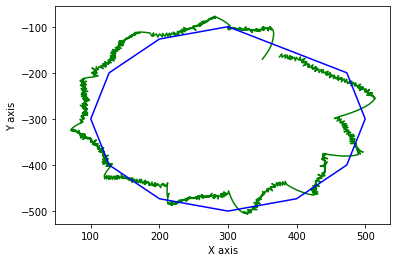

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(traj[1:, 0], traj[1:, 1], color='g')
plt.plot(T[:, 0], T[:, 1], color='b')
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.show()
fig.savefig('predict30.pdf', dpi=600, format='pdf')

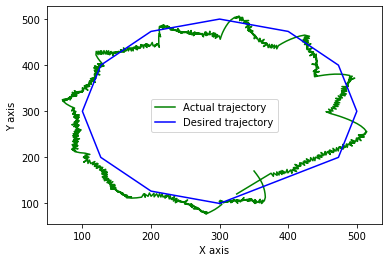

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(trak[1:, 0], trak[1:, 1], color='g', label = 'Actual trajectory')
plt.plot(T[:, 0], T[:, 1], color='b', label = 'Desired trajectory')
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.legend()
plt.show()
fig.savefig('predicts30.pdf', dpi=600, format='pdf')